In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
#from keras.applications.resnet50 import resnet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [3]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = 'train'
valid_path = 'val'
test_path = 'test'

In [6]:
# useful for getting number of output classes
folders = glob('train/*')

In [7]:
folders

['train\\Healthy', 'train\\Unhealthy']

In [4]:
# Import the ResNet50 library as shown below and add preprocessing layer to the front of ResNet50
# Here we will be using imagenet weights

resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

94773248/94765736 [==============================] - 25s 0us/step


In [5]:
# don't train existing weights
for layer in resnet.layers:
    layer.trainable = False

In [8]:
# our layers - you can add more if you want
x = Flatten()(resnet.output)

In [9]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=resnet.input, outputs=prediction)

In [10]:
# view the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [11]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [12]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [13]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 4693 images belonging to 2 classes.


In [14]:
validation_set = train_datagen.flow_from_directory('val',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 1564 images belonging to 2 classes.


In [15]:
test_set = test_datagen.flow_from_directory('test',
                                            target_size = (224, 224),
                                            batch_size = 1,
                                            class_mode = 'categorical')

Found 1564 images belonging to 2 classes.


In [16]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=validation_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(validation_set)
)

C:\Users\DELL\anaconda3\envs\marzharenv\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
147/147 [==============================] - 75s 478ms/step - loss: 0.9196 - accuracy: 0.6799 - val_loss: 0.6179 - val_accuracy: 0.6714
Epoch 2/5
147/147 [==============================] - 72s 488ms/step - loss: 0.3403 - accuracy: 0.8410 - val_loss: 0.1949 - val_accuracy: 0.9412
Epoch 3/5
147/147 [==============================] - 74s 502ms/step - loss: 0.2662 - accuracy: 0.8860 - val_loss: 0.4406 - val_accuracy: 0.7762
Epoch 4/5
147/147 [==============================] - 75s 509ms/step - loss: 0.2147 - accuracy: 0.9152 - val_loss: 0.1538 - val_accuracy: 0.9546
Epoch 5/5
147/147 [==============================] - 76s 520ms/step - loss: 0.1573 - accuracy: 0.9423 - val_loss: 0.1153 - val_accuracy: 0.9674


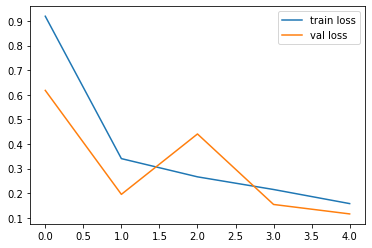

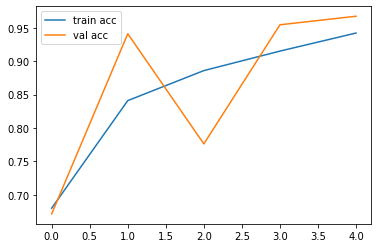

<Figure size 432x288 with 0 Axes>

In [17]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [18]:
from tensorflow.keras.models import load_model

model.save('logs/model_phcresnet50.h5')

C:\Users\DELL\anaconda3\envs\marzharenv\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [19]:
test_loss, test_acc = model.evaluate(test_set, verbose=2)
print('\nTest accuracy:', test_acc)
print('\nTest loss:', test_loss)

1564/1564 - 25s - loss: 0.5265 - accuracy: 0.8012

Test accuracy: 0.801150918006897

Test loss: 0.5265122652053833


test accuracy : 80.1150895140665


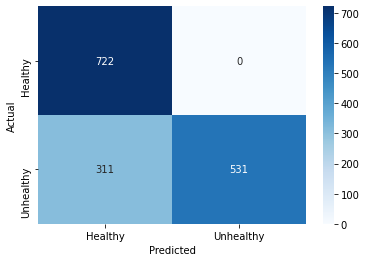

In [25]:
import pandas as pd
import seaborn as sn
import tensorflow as tf

model = tf.keras.models.load_model('logs/model_phcresnet50.h5')
filenames = test_set.filenames
nb_samples = len(test_set)
y_prob=[]
y_act=[]
test_set.reset()
for _ in range(nb_samples):
   X_test,Y_test = test_set.next()
   y_prob.append(model.predict(X_test))
   y_act.append(Y_test)

predicted_class = [list(training_set.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(training_set.class_indices.keys())[i.argmax()] for i in y_act]

out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns=['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix,cmap='Blues', annot=True,fmt='d')
plt.show
print('test accuracy : {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))